In [22]:
# core scientific libraries
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# secondary libraries
import netCDF4 as nc
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, CoordPair, vertcross, g_uvmet, interpline, destagger,
                interp2dxy, ll_to_xy, xy, ALL_TIMES, vinterp)
import metpy.calc as mpcalc
from metpy.units import units

import pytz

from xarray.backends.netCDF4_ import NetCDF4DataStore

import copy 

In [23]:
def plot_cross_section(data, pot_data, terrian, levels_data, levels_pot, data_cols, data_units, data_title, \
                       data_name, outdir, lines_lat, lines_col, y_max, mnt_labels, mnt_labs_pos):
    ''' plot cross section'''
    
    # save vertical and horizontal coordinates
    vert = data['z'].sel(z = slice(0, y_max))
    hor = data['lat']
    
    # Start Figure
    fig = plt.figure(figsize=(12, 6))

    # Specify plotting axis (single panel)
    ax = plt.subplot(111)

    cf = ax.contourf(hor, vert, data.sel(z = slice(0, y_max))[:,:,0].values, cmap = data_cols, \
                         extend = 'both', levels = levels_data)

    # Theta contours 
    theta_contours = ax.contour(hor, vert, pot_data.sel(z = slice(0, y_max))[:,:,0].values, colors = 'k', levels = levels_pot)

    plt.clabel(theta_contours, fmt='%d',fontsize=8.5, inline_spacing=5, inline = 1)

    ct = ax.fill_between(hor, 0, terrian[:,0].values, facecolor = "silver")

    cb = plt.colorbar(cf, ax=ax, label = data_units)
    
    ax.set_xlabel("Latitude along Longitude " + str(data['lon'][0].values), fontsize=12)
    ax.set_ylabel("Height (m)", fontsize=12)
    
    # add labels for SYM and SRM
    props = dict(facecolor='silver', edgecolor = 'silver')
    
    if (mnt_labels == True):
        # add labels for SYM and SRM
        props = dict(facecolor='silver', edgecolor = 'silver')

        ax.text(mnt_labs_pos[0], mnt_labs_pos[1], 'SYM', fontsize = 15, transform = ax.transAxes, bbox = props)
        ax.text(mnt_labs_pos[2], mnt_labs_pos[3], 'SRM', fontsize = 15, transform = ax.transAxes, bbox = props) 
    
    n_lines = len(lines_lat)
    
    for i in range(n_lines):
        plt.plot([lines_lat[i], lines_lat[i]], [0,y_max] , color = lines_col[i], linestyle = 'dashed')
    
    # Make title of datatime and second title for date time
    plt.title(data_title)
    plt.title(str(data['time'].values)[:16].replace('T',' ') + ' PDT', loc = 'right')
    
    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '_' \
            + str(data['time'].values)[:13].replace('/','_').replace(' ','_').replace('T','_').replace('-','_') + \
                '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

In [24]:
# Set filepath
#Duine 2019 non fire western case study 
# datdir = '/home/sbarc/wrf/wrf401/sundowners/20170311/run-64452560-z0-SMOIS200/'
# filename = 'wrfout_d04_2017-03-10_18:00:00'

# Non-sundowner
datdir = '../input_data/'
filename = 'wrfout_d03_2017-05-22_00:00:00'

# #Cannon Case Study Non-sundowner
# datdir = '/home/sundowners/non-sundowner/2004/'
# filename = 'wrfout_d04_2004-04-29_00:00:00'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/data'


# open wrf Dataset object
filepath = datdir + filename
print('Opened File:', filepath, '\n')

# Open NetCDF Dataset object
f = nc.Dataset(filepath,'r')

# List variable names
#print("Variables:")
#print(f.variables.keys(),'\n')

# Show variavles and all details
#print(f.variables.items(),'\n')

# Show dimension names and sizes
#print("Dimensions:")
#print(f.dimensions.items(),'\n')

# Print all file metadata
#print(f)   # or run 'ncdump -h <filename>' in terminal

Opened File: ../input_data/wrfout_d03_2017-05-22_00:00:00 



In [25]:
# specify desired variables to grad from the wrf out file and their units
des_vars = ["theta", "ua", "va", "wa"]
var_units = ["K", "m s-1", "m s-1", "m s-1"]

# specify the z levels to interpolate to [km]
v_levels = np.arange(0, 21, 0.05)

# specify the time index desired
indx = 3
# indx = ALL_TIMES

# make empty list to append interpolated dataarrays too
data = []

for i in range(len(des_vars)):
    
    # grab var with units at time index
    tmp = getvar(f, des_vars[i], units = var_units[i], timeidx = indx)

    # interpolate to z levels
    tmp_interp = vinterp(wrfin = f, field = tmp, vert_coord = 'ght_msl', interp_levels = v_levels, timeidx = indx)
   
    # append to list
    data.append(tmp_interp)
    
    
# merge into one dataset    
data = xr.merge(data)

# add terrian height to dataset
data['terr'] = getvar(f, "ter", units = 'm', timeidx = indx)

# pull lat and lon vallues and replace current corrdinates
lats = data.XLAT.values[:,0]
lons = data.XLONG.values[0,:]

data['south_north'] = lats
data['west_east'] = lons

# remane dimensions with ugly names
data = data.rename({'south_north':'lat', 'west_east':'lon', 'XTIME':'time', 'XLAT':'lat_grid', 
                    'XLONG':'lon_grid', 'interp_level':'z'})

# change vertical coordinates to meters
data['z'] = data['z']*1000

# fix the time coordinates
data['time'] = data['Time']
data = data.drop("Time")

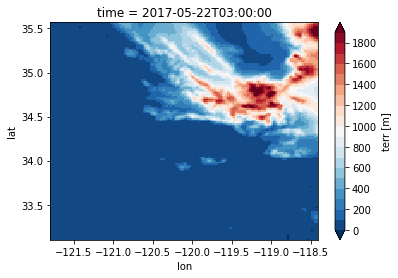

In [26]:
data['terr'].plot(levels = np.arange(0, 2000, 100))

In [27]:
# choose cross section starting and ending lat and lons
cross_lats = [35.50267, 33.50865]
cross_lons = [-119.65, -119.66] # must only include one longitude point

# save thetas, vertical velocities, topo heights, and pbl height through the cross section
cross_data = data.sel(lat = slice(cross_lats[1], cross_lats[0]), 
                     lon = slice(cross_lons[1], cross_lons[0]))

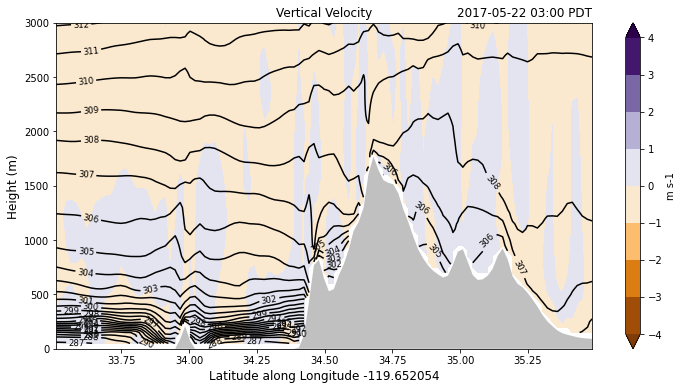

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/figures/vertical_velocity_2017_05_22_03.png 



In [28]:
# specify location of SYM and SRM labels and if you want them
labs_pos = [0.24, 0.1, 0.44, 0.35]
lab_key = False
    
var_no = 3
varz = ['', '', 'v', 'w']
var_names = ['', '', 'merd_velocity', 'vertical_velocity']
var_titles = ['', '', 'Meridional Velocity', 'Vertical Velocity']

var_colors = ['', '', 'PuOr', 'PuOr']
var_levels = ['', '', np.arange(-20, 21, 1), np.arange(-4, 5, 1)]

var = des_vars[var_no]
var_unit = var_units[var_no]

var_name = var_names[var_no]
var_title = var_titles[var_no]
var_color = var_colors[var_no]
levels = var_levels[var_no]

# choose colorbar levels for theta
dmax = np.ceil(np.nanmax(data['theta'].values))
dmin = np.floor(np.nanmin(data['theta'].values))
levelst = np.arange(dmin, dmax + 1, 1)
    
plot_cross_section(cross_data[var], \
                   cross_data['theta'], \
                   cross_data['terr'], levels, levelst, var_color, var_unit, \
                    var_title, var_name, fig_outdir, [], [], 3000, lab_key, labs_pos)

# plot_cross_section(da[var].sel(time = str(da.time[timestep].values)), \
#                    da['theta'].sel(time = str(da.time[timestep].values)), \
#                    da['hgt'], levels, levelst, var_color, var_unit, \
#                     var_title, var_name, outdir, [], [])